In [1]:
import pandas as pd 
import numpy as np 
from scipy import stats as st
from scipy.stats import norm, ttest_ind, anderson_ksamp
import matplotlib.pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power 
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.proportion import proportions_ztest
import pylab 

# Проект по A/B - тестам.

In [2]:
#`chat_id ` из Телеграма:
chat_id = 1003183520

##  <ins>Задание 1.</ins>

**Общее описание**

В этом задании необходимо провести A/B тест на процессе продажных обзвонов. Алгоритм решения задачи следующий:

- Напишите боту @TFDataAnalysisBot команду /get_project1_desc. Так вы получите условие и файл с историческими данными.
- Определите целевую метрику и альтернативу.
- Исходя из исторических данных, определите минимальный размер n одной выборки.
- Напишите боту команду /get_project1_sample n, где n - минимальный размер выборки.
- Примените критерий и сделайте вывод об успешности или неуспешности теста.

**Описание данных**

Процесс продажи устроен следующим образом:

- создаётся задание на звонок человеку;
- оператор берёт задание и пытается дозвониться до человека;
- если не дозванивается, мы несём некоторые затраты на время оператора и поддержку инфраструктуры;
- если дозванивается, пытается продать наш продукт;
- если продал, мы имеем некоторый заработок (PV) и повышенные расходы (в том числе на вознаграждение оператора).

**Описание колонок в исторических данных**

- ID - номер задания на звонок
- Флаг дозвона - 1 если в рамках задания мы дозвонились человеку, иначе 0
- Флаг продажи - 1 если в рамках задания мы продали наш продукт человеку, иначе 0
- Расходы - сумма затрат на задание
- PV - 0 если мы не продали наш продукт, иначе = PV проданного продукта
- NPV = PV - Расходы

### 0. Запрос у бота в Телеграме условие командой `/get_project1_desc`

**Контекст**

Мы считаем, что наш продукт достаточно дорогой для клиента.
У нас есть гипотеза, что уменьшение цены продукта
позволит повысить частоту продаж
и суммарно увеличит доходность продукта.
        
**Тест**

Мы проводим тест,
в рамках которого контролем является
продажа продукта со старой ценой,
а тестом - продажа продукта с новой ценой.
Целью этого теста
является проверка гипотезы роста доходности
нашего продукта из-за уменьшения тарифа.

Статистические вводные:
- Уровень значимости 5%.
- Мы хотели бы различать 5%-ное
изменение целевой метрики
с вероятностью 80%.

### 1. Выбор метрик

В качестве целевой метрики возьмем NPV, так как она учитывает расходы. Мы уменьшаем стоимость продукта, поэтому надо следить за "чистой" прибылью. PV в качестве целевой метрики не подходит, так как доход может увеличиться, а Profit (чистая прибыль) может упасть. 

В качестве контрольной метрики возьмем количество успешных сделок (столбец - флаг продажи). Количество успешных сделок в группе B не должно быть меньше чем в группе А.

### 2. Альтернатива в критерии

H0: Среднее NPV группы А больше или равно среднему NPV группы В. 

H1: Среднее NPV группы А меньше среднего NPV группы В. 

$H_0 : \bar{x}_{A} >= \bar{x}_{B}$ 

$H_1 : \bar{x}_{A} < \bar{x}_{B}$

### 3.1. Рассчет размера выборки

In [3]:
# историчесокие данные 

df_hist = pd.read_csv('hist_telesales.csv')
df_hist.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,1,0,90,0,-90
1,1,0,0,5,0,-5
2,2,0,0,68,0,-68
3,3,1,0,22,0,-22
4,4,1,0,22,0,-22


In [4]:
df_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72161 entries, 0 to 72160
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            72161 non-null  int64
 1   Флаг дозвона  72161 non-null  int64
 2   Флаг продажи  72161 non-null  int64
 3   Расходы       72161 non-null  int64
 4   PV            72161 non-null  int64
 5   NPV           72161 non-null  int64
dtypes: int64(6)
memory usage: 3.3 MB


In [5]:
df_hist.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,72161.0,36080.000000,20831.230725,0.0,18040.0,36080.0,54120.0,72160.0
Флаг дозвона,72161.0,0.599881,0.489926,0.0,0.0,1.0,1.0,1.0
Флаг продажи,72161.0,0.302172,0.459202,0.0,0.0,0.0,1.0,1.0
Расходы,72161.0,200.581547,363.748786,0.0,21.0,59.0,182.0,6280.0
PV,72161.0,482.041352,814.227243,0.0,0.0,0.0,1258.0,41255.0
NPV,72161.0,281.459805,677.664908,-4406.0,-54.0,-18.0,535.0,41144.0


Рассчитаем размер выборок двумя способами: с помощью tt_ind_solve_power и формулы для небинарного распределения и односторонней альтернативы.

In [6]:
alpha = 0.05    # уровень значимости
power = 0.8    # мощность теста
lift = 0.05   # относительный прирост 
mean_npv_hist = df_hist['NPV'].mean() # историческое среднее метрики 
mde = lift * mean_npv_hist           # mde
std_npv_hist = df_hist['NPV'].std() # историческое стандартное отклонение метрики 
effect_size = mde / std_npv_hist   # размер эффекта 

# наблюдения на одну выборку округленное до целого числа 

n = round((tt_ind_solve_power(
    effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='larger')
))
print(f'Размер каждой из групп для теста: {n}')

Размер каждой из групп для теста: 28673


In [7]:
# сравним результат функции с формулой для небинарного распределения и односторонней альтернативы
z_alpha = st.norm.ppf(1 - alpha)
z_beta = st.norm.ppf(1 - power) 

n1 = 2 * std_npv_hist**2 * (z_alpha - z_beta)**2 / mde**2

round(n1)

28672

Результаты сходятся, для дальнейшей проверки буду использовать выборку n = 28673

### 3.2. Запрос у бота в Телеграме выборку командой `/get_project1_sample {размер выборки}` и вписать код выборки

In [8]:
cod_v = 4726 # код выборки

# Файлы для теста

df_a = pd.read_csv('Контроль.csv')
df_b = pd.read_csv('Тест.csv')

In [9]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28673 entries, 0 to 28672
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            28673 non-null  int64
 1   Флаг дозвона  28673 non-null  int64
 2   Флаг продажи  28673 non-null  int64
 3   Расходы       28673 non-null  int64
 4   PV            28673 non-null  int64
 5   NPV           28673 non-null  int64
dtypes: int64(6)
memory usage: 1.3 MB


In [10]:
df_a.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,28673.0,14336.000000,8277.326471,0.0,7168.0,14336.0,21504.0,28672.0
Флаг дозвона,28673.0,0.602867,0.489313,0.0,0.0,1.0,1.0,1.0
Флаг продажи,28673.0,0.303910,0.459952,0.0,0.0,0.0,1.0,1.0
Расходы,28673.0,200.841384,360.286854,0.0,21.0,59.0,185.0,4224.0
PV,28673.0,486.192829,794.450900,0.0,0.0,0.0,1257.0,9649.0
NPV,28673.0,285.351446,649.234384,-2886.0,-54.0,-17.0,548.0,8052.0


In [11]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28673 entries, 0 to 28672
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            28673 non-null  int64
 1   Флаг дозвона  28673 non-null  int64
 2   Флаг продажи  28673 non-null  int64
 3   Расходы       28673 non-null  int64
 4   PV            28673 non-null  int64
 5   NPV           28673 non-null  int64
dtypes: int64(6)
memory usage: 1.3 MB


In [12]:
df_b.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,28673.0,14336.000000,8277.326471,0.0,7168.0,14336.0,21504.0,28672.0
Флаг дозвона,28673.0,0.597635,0.490383,0.0,0.0,1.0,1.0,1.0
Флаг продажи,28673.0,0.297388,0.457117,0.0,0.0,0.0,1.0,1.0
Расходы,28673.0,197.799742,361.309959,0.0,21.0,58.0,176.0,4510.0
PV,28673.0,475.735710,795.316713,0.0,0.0,0.0,1251.0,13884.0
NPV,28673.0,277.935968,654.273899,-3010.0,-54.0,-18.0,501.0,13235.0


### 4. Принятие решения

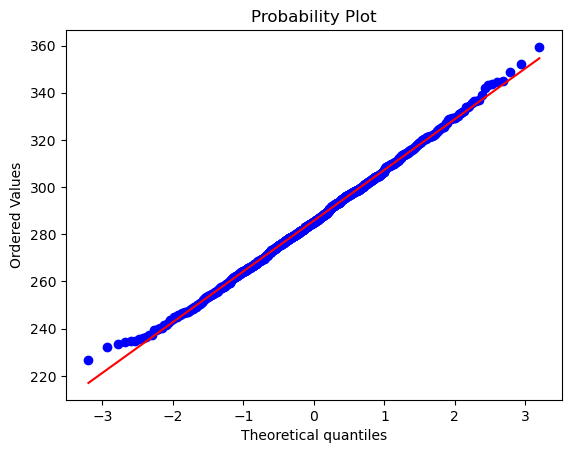

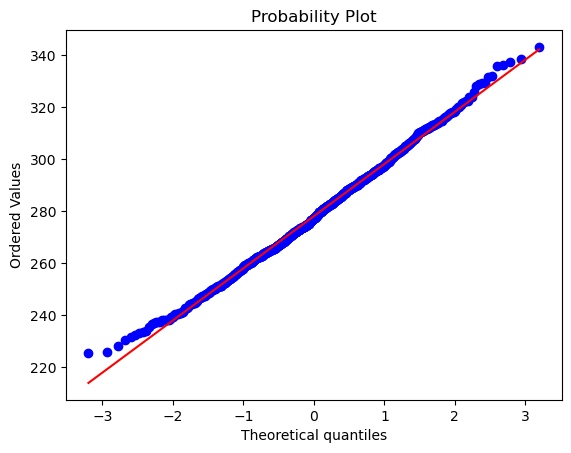

In [13]:
# Для ttest проверим, что выборочные средние распределены нормально

a = pd.Series([df_a['NPV'].sample(1000,replace=True).mean() for _ in range(1000)])
b = pd.Series([df_b['NPV'].sample(1000,replace=True).mean() for _ in range(1000)])

st.probplot(a, dist="norm", plot=pylab)
pylab.show()

st.probplot(b, dist="norm", plot=pylab)
pylab.show()

In [14]:
# ttest с односторонней проверкой alternative = 'less'

_, pval = ttest_ind(a = df_a['NPV'], b = df_b['NPV'], equal_var=False, alternative = 'less')
pval

0.9134461644312128

In [15]:
print(f'''Среднее NPV группы А: {df_a['NPV'].mean()}, количество продаж группы А: {df_a['Флаг продажи'].sum()};
Среднее NPV группы B: {df_b['NPV'].mean()}, количество продаж группы B: {df_b['Флаг продажи'].sum()} ''')

Среднее NPV группы А: 285.35144561085343, количество продаж группы А: 8714;
Среднее NPV группы B: 277.93596763505735, количество продаж группы B: 8527 


<div style="border:solid green 2px; padding: 20px"> 
<b>Вывод по заданию 1:</b> 
    
p-value больше 0.05, следовательно отклонить гипотезу H0 мы не можем; количество продаж и NPV в контольной группе больше больше чем в тестовой. В тестовой и контрольной группе примерно одинаковое количество недозвонов. Можно сделать вывод, что уменьшение цены продукта не приносит больше больше прибыли и успешных сделок. 
</div>

------------------

##  <ins>Задание 2.</ins>

**Общее описание**

В этом задании необходимо провести A/B тест на процессе оформления кредитных карт. Алгоритм решения задачи следующий.

- Напишите боту @TFDataAnalysisBot команду /get_project2_desc. Так вы получите условие и файл с историческими данными.
- Определите целевую метрику и альтернативу.
- Определите параметр, влияющий на целевую метрику.
- Исходя из исторических данных, определите минимальный размер n одной выборки.
- Напишите боту команду /get_project2_sample n, где n - минимальный размер выборки.
- Проверьте однородность выборок. (Если выборки неоднородны, то тест провален. Если выборки однородны, примените критерий для целевой метрики.)
- Выводы по тесту.

**Описание данных**

Процесс оформления кредитной карты (КК) устроен следующим образом:

- человек заходит на сайт и заполняет информацию о себе (в том числе возраст и доход клиента) для получения кредитной карты;
- человек проходит скоринг (в том числе в рамках которого оценивается вероятность банкротства клиента);
- создаётся заявка на оформление кредитной карты;
- человеку выпускается виртуальная карта, а также предлагается наша услуга к этому счёту;
- с некоторой вероятностью человек утилизирует счёт (начинает им пользоваться);
- если человек не утилизирует счёт, мы несём некоторые затраты на время оператора и поддержку инфраструктуры;
- если человек утилизировал карту, мы имеем некоторый заработок (PV) и повышенные расходы.

**Описание колонок в исторических данных.**

- ID - номер заявки, прошедшей скоринг
- Возраст - возраст клиента, указанный при оформлении КК
- Доход клиента - доход клиента, указанный при оформлении КК
- Вероятность банкротства - оценка вероятности банкротства клиента, полученная с помощью скоринга по параметрам клиента
- Флаг утилизация счёта - совершение первой расходной операции на счёте КК
- Расходы - сумма затрат на заявку
- PV КК - 0 если счёт не утилизирован, иначе = PV кредитной карты
- PV услуги - 0 если счёт не утилизирован, иначе = PV этой услуги
- NPV = PV КК + PV услуги - Расходы

### 0. Запрос у бота в Телеграме условие командой `/get_project2_desc`

**Контекст**

Мы провели Cust Dev и поняли,
что форма авторизации для клиента сложна,
и из-за этого часть клиентов
отваливается в заявочном процессе.
Мы решили разработать
новый процесс авторизации,
и у нас есть гипотеза,
что он позволит повысить
утилизации наших счетов.
        
**Тест**

Мы проводим тест,
в рамках которого мы разбиваем весь поток
на две части рановероятно,
где у одной части (контроля) 
старый процесс авторизации,
а у второй части (теста) - новый.
Целью этого теста
является повышение утилизаций счёта.

Статистические вводные

- Проверка однородности выбранного параметра
осуществяется с уровнем значимости 2%.

- Уровень значимости 5%.
- Мы хотели бы различать 3%-ное
изменение целевой метрики
с вероятностью 95%.

### 1. Выбор метрик

В качестве целевой метрики возьмем 'Флаг утилизация счёта', так как цель теста - увеличение количества утилизированных карт.

### 2. Альтернатива в критерии

H0: Частота утилизации счета группы А равна частоте утилизации счета группы В. 

H1: Частота утилизации счета группы А меньше частоты утилизации счета группы В. 

$H_0 : p_{A} = p_{B}$ 

$H_1 : p_{A} < p_{B}$

### 3. Выбор параметра, влияющего на целевую метрику

In [16]:
# историчесокие данные 

df_hist_card = pd.read_csv('hist_credit_card.csv')
df_hist_card.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,19,21620.835463,0.138061,0,102,0,0,-102
1,1,27,24897.990863,0.035508,1,409,11686,1754,13031
2,2,50,23989.526947,0.098793,0,16,0,0,-16
3,3,18,38442.409756,0.365661,1,788,13738,1578,14528
4,4,24,21291.521612,0.036909,1,1048,6594,2213,7759


In [17]:
df_hist_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123255 entries, 0 to 123254
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       123255 non-null  int64  
 1   Возраст                  123255 non-null  int64  
 2   Доход клиента            123255 non-null  float64
 3   Вероятность банкротства  123255 non-null  float64
 4   Флаг утилизации счёта    123255 non-null  int64  
 5   Расходы                  123255 non-null  int64  
 6   PV КК                    123255 non-null  int64  
 7   PV услуги                123255 non-null  int64  
 8   NPV                      123255 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 8.5 MB


In [18]:
df_hist_card.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,123255.0,61627.000000,35580.798052,0.000000e+00,30813.500000,61627.000000,92440.500000,1.232540e+05
Возраст,123255.0,39.673522,16.449416,1.800000e+01,25.000000,36.000000,52.000000,7.500000e+01
Доход клиента,123255.0,30093.852754,17487.759048,2.000019e+04,22017.727203,25234.737307,31838.232301,1.187963e+06
Вероятность банкротства,123255.0,0.125425,0.110504,5.004337e-08,0.040535,0.094759,0.180180,8.601029e-01
Флаг утилизации счёта,123255.0,0.741544,0.437788,0.000000e+00,0.000000,1.000000,1.000000,1.000000e+00
Расходы,123255.0,421.941942,486.166550,0.000000e+00,74.000000,252.000000,600.000000,5.178000e+03
PV КК,123255.0,7496.048574,21589.615841,0.000000e+00,0.000000,6316.000000,8807.000000,5.073883e+06
PV услуги,123255.0,1486.105253,1357.035726,0.000000e+00,0.000000,1518.000000,1916.000000,7.505800e+04
NPV,123255.0,8560.211886,21758.627389,-5.100000e+02,-1.000000,7755.000000,10448.000000,5.075041e+06


In [19]:
# посмотрим на корреляцию 'Флаг утилизации счёта' с другими столбцами

df_hist_card.corr()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
ID,1.000000,-0.002624,0.004518,0.001279,-0.000964,-0.000077,-0.003181,-0.005220,-0.003480
Возраст,-0.002624,1.000000,0.001514,-0.004102,0.007277,0.002460,0.003447,0.006117,0.003747
Доход клиента,0.004518,0.001514,1.000000,-0.000882,0.000706,0.001032,-0.002142,-0.001937,-0.002269
Вероятность банкротства,0.001279,-0.004102,-0.000882,1.000000,-0.215398,-0.099635,-0.043319,-0.139128,-0.049433
Флаг утилизации счёта,-0.000964,0.007277,0.000706,-0.215398,1.000000,0.452036,0.204981,0.646524,0.233611
Расходы,-0.000077,0.002460,0.001032,-0.099635,0.452036,1.000000,0.090826,0.294538,0.086146
PV КК,-0.003181,0.003447,-0.002142,-0.043319,0.204981,0.090826,1.000000,0.128742,0.998232
PV услуги,-0.005220,0.006117,-0.001937,-0.139128,0.646524,0.294538,0.128742,1.000000,0.183529
NPV,-0.003480,0.003747,-0.002269,-0.049433,0.233611,0.086146,0.998232,0.183529,1.000000


Нас интересуют только те параметры, которые доступны до прохода человека по процессу заявки (соц-дем, параметры скоринга): Возраст, Доход клиента, Вероятность банкротства. В качестве параметра, влияющего на целeвую метрику будем рассматривать 'Вероятность банкротства', так как у этого параметра самоя большая корреляция (-0.22) и его можно использовать для дальнейшей проверки однородности выборок.

### 4.1. Рассчет размера выборки

In [20]:
alpha_card = 0.05   # уровень значимости
power_card = 0.95   # мощность теста
lift_card = 0.03    # относительный прирост 
p0 = df_hist_card['Флаг утилизации счёта'].mean()  # вероятность утилизации счета в исторических данных
mde_card = p0 * lift_card   # mde

# посчитаем размеры групп формулой для бинарного распределения и односторонней альтернативы

z_alpha_card = st.norm.ppf(1 - alpha_card)
z_beta_card = st.norm.ppf(1 - power_card) 
n_card = round(2 * p0 * (1 - p0) * (z_alpha_card - z_beta_card)**2 / mde_card**2)

print(f'Размер каждой из групп для теста: {n_card}')

Размер каждой из групп для теста: 8382


### 4.2. Запрос у бота в Телеграме выборку командой `/get_project2_sample {размер выборки}` и вписать код выборки

In [21]:
cod_v_card = 56882  # код выборки 

In [22]:
# Файлы для теста

df_a_card = pd.read_csv('Контроль (1).csv')
df_b_card = pd.read_csv('Тест (1).csv')

In [23]:
df_a_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8382 entries, 0 to 8381
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       8382 non-null   int64  
 1   Возраст                  8382 non-null   int64  
 2   Доход клиента            8382 non-null   float64
 3   Вероятность банкротства  8382 non-null   float64
 4   Флаг утилизации счёта    8382 non-null   int64  
 5   Расходы                  8382 non-null   int64  
 6   PV КК                    8382 non-null   int64  
 7   PV услуги                8382 non-null   int64  
 8   NPV                      8382 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 589.5 KB


In [24]:
df_a_card.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,8382.0,4190.500000,2419.819311,0.000000e+00,2095.250000,4190.500000,6285.750000,8381.000000
Возраст,8382.0,39.740754,16.445009,1.800000e+01,25.000000,36.000000,52.000000,75.000000
Доход клиента,8382.0,30037.629819,17091.332881,2.000018e+04,22035.962092,25202.141111,31414.181071,456300.012436
Вероятность банкротства,8382.0,0.125725,0.110928,5.090969e-07,0.041128,0.094759,0.178834,0.782285
Флаг утилизации счёта,8382.0,0.740873,0.438181,0.000000e+00,0.000000,1.000000,1.000000,1.000000
Расходы,8382.0,414.740754,472.917087,0.000000e+00,72.000000,250.000000,593.000000,4805.000000
PV КК,8382.0,7485.761632,16345.304276,0.000000e+00,0.000000,6257.000000,8677.000000,883230.000000
PV услуги,8382.0,1473.816989,1250.154550,0.000000e+00,0.000000,1521.000000,1916.000000,32747.000000
NPV,8382.0,8544.837867,16566.422424,-3.910000e+02,-1.000000,7667.000000,10275.750000,884810.000000


In [25]:
df_b_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8382 entries, 0 to 8381
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       8382 non-null   int64  
 1   Возраст                  8382 non-null   int64  
 2   Доход клиента            8382 non-null   float64
 3   Вероятность банкротства  8382 non-null   float64
 4   Флаг утилизации счёта    8382 non-null   int64  
 5   Расходы                  8382 non-null   int64  
 6   PV КК                    8382 non-null   int64  
 7   PV услуги                8382 non-null   int64  
 8   NPV                      8382 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 589.5 KB


In [26]:
df_b_card.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,8382.0,4190.500000,2419.819311,0.000000,2095.250000,4190.500000,6285.750000,8.381000e+03
Возраст,8382.0,39.871630,16.604088,18.000000,25.000000,37.000000,53.000000,7.500000e+01
Доход клиента,8382.0,29703.569358,18431.707621,20000.262678,22066.827136,25032.027765,31482.859456,1.074573e+06
Вероятность банкротства,8382.0,0.125455,0.110929,0.000012,0.040237,0.093504,0.181008,7.216904e-01
Флаг утилизации счёта,8382.0,0.762944,0.425302,0.000000,1.000000,1.000000,1.000000,1.000000e+00
Расходы,8382.0,429.944285,487.973090,0.000000,80.250000,263.000000,612.000000,4.934000e+03
PV КК,8382.0,7732.363994,13013.176214,0.000000,5279.000000,6412.000000,8986.750000,7.287190e+05
PV услуги,8382.0,1519.006323,1247.155170,0.000000,1339.000000,1524.000000,1929.000000,2.967000e+04
NPV,8382.0,8821.426032,13262.817870,-463.000000,5771.000000,7847.000000,10584.500000,7.297540e+05


### 5. Проверка на однородность, применение критерия. Принятие решения. 

Для проверки однородности будем использовать критерий anderson_ksamp, в качестве параметра - 'Вероятность банкротства'

$H_0: F = G$

$H_1: F \neq G$

In [30]:
alpha_anderson_ksamp = 0.02   # уровень значимости из условия

test_stat, _, p_value = (anderson_ksamp(
    [np.array(df_a_card['Вероятность банкротства']), np.array(df_b_card['Вероятность банкротства'])])
)

if p_value < alpha_anderson_ksamp:
    print(f"""Отвергаем нулевую гипотезу, 
p_value = {p_value}, 
Вероятность банкротства в группе А: {df_a_card['Вероятность банкротства'].mean()},
Вероятность банкротства в группе B: {df_b_card['Вероятность банкротства'].mean()}""")
else:
    print(f"""Не получилось отвергнуть нулевую гипотезу, 
p_value = {p_value},
Вероятность банкротства в группе А: {df_a_card['Вероятность банкротства'].mean()},
Вероятность банкротства в группе B: {df_b_card['Вероятность банкротства'].mean()})""")

Не получилось отвергнуть нулевую гипотезу, 
p_value = 0.25,
Вероятность банкротства в группе А: 0.1257252928715859,
Вероятность банкротства в группе B: 0.12545513460342744)


/var/folders/nz/rwcnsk891c79hvd5q73_5xfr0000gn/T/ipykernel_8993/2284598100.py:3: UserWarning: p-value capped: true value larger than 0.25
  test_stat, _, p_value = (anderson_ksamp(


Делаем вывод, что выборки однородны, можно проводить A/B тест.

In [28]:
# В качестве критерия для теста будем использовать proportions_ztest с односторонней альтернативой

a_success = df_a_card['Флаг утилизации счёта'].sum() # кол-во утилизаций в группе А
b_success = df_b_card['Флаг утилизации счёта'].sum() # кол-во утилизаций в группе В
a_cnt = df_a_card['Флаг утилизации счёта'].count() # общее кол-во в группе А
b_cnt = df_b_card['Флаг утилизации счёта'].count() # общее кол-во в группе В

# proportions_ztest с alternative='smaller'

_, p_value = proportions_ztest([a_success, b_success], [a_cnt, b_cnt], alternative='smaller')

if p_value < alpha_card:
    print(f"""Отвергаем нулевую гипотезу, 
p_value = {p_value}, 
процент утилизированных карт в группе А: {a_success / a_cnt * 100},
процент утилизированных карт в группе B: {b_success / b_cnt * 100}""")
else:
    print(f"""Не получилось отвергнуть нулевую гипотезу, 
p_value = {p_value}, 
процент утилизированных карт в группе А: {a_success / a_cnt * 100},
процент утилизированных карт в группе B: {b_success / b_cnt * 100}""")

Отвергаем нулевую гипотезу, 
p_value = 0.00046945144502257095, 
процент утилизированных карт в группе А: 74.0873299928418,
процент утилизированных карт в группе B: 76.2944404676688


<div style="border:solid green 2px; padding: 20px"> 
<b>Вывод по заданию 2:</b> 
    
Тест на однородность с параметром 'Вероятность банкротства' показал, что выборки пригодны для А/В теста. p-value из proportions_ztest меньше 0.05, следовательно мы отклоняем гипотезу H0 и делаем вывод, что новый процесс авторизации действительно позволяет повысить утилизации наших счетов.

</div>